# Introduction

In this notebook we use deep learning techniques on the dataset we earlier created to create full end-to-end data science pipeline.

# Libraries

In [1]:
import matplotlib
matplotlib.use("svg")
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import numpy as np
import pandas as pd
import os

## Installation

In [2]:
# Theano
# Keras

# Image Dataset

In [3]:
fullpath = "../Dataset/image_census_info.csv"
df_img = pd.read_csv(fullpath, sep=',')
df_img.head()

ImageName        Lat       Long                GEOID  \
0  Pittsburgh00182.png  40.499737 -80.015609  15000US420032612001   
1  Pittsburgh00316.png  40.498437 -80.017309  15000US420032612001   
2  Pittsburgh00317.png  40.498437 -80.015609  15000US420032612001   
3  Pittsburgh00318.png  40.498437 -80.013909  15000US420032612001   
4  Pittsburgh00319.png  40.498437 -80.012209  15000US420032612001   

   MEDIAN_INCOME  
0        56691.0  
1        56691.0  
2        56691.0  
3        56691.0  
4        56691.0

In [4]:
len(df_img)

7299

In [5]:
len(df_img[df_img.MEDIAN_INCOME.notnull()])

6435

In [6]:
df_img = df_img[df_img.MEDIAN_INCOME.notnull()]
df_img.reset_index(drop=True, inplace=True)

In [7]:
df_img.head()

ImageName        Lat       Long                GEOID  \
0  Pittsburgh00182.png  40.499737 -80.015609  15000US420032612001   
1  Pittsburgh00316.png  40.498437 -80.017309  15000US420032612001   
2  Pittsburgh00317.png  40.498437 -80.015609  15000US420032612001   
3  Pittsburgh00318.png  40.498437 -80.013909  15000US420032612001   
4  Pittsburgh00319.png  40.498437 -80.012209  15000US420032612001   

   MEDIAN_INCOME  
0        56691.0  
1        56691.0  
2        56691.0  
3        56691.0  
4        56691.0

In [8]:
from PIL import Image

def plot_image(im):
    plt.imshow(np.asarray(im)) 

PNG (640, 640) P


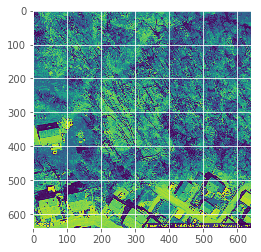

In [9]:
img_path = os.path.join("../Image/")

im_pitts_0 = Image.open(img_path+df_img.ImageName[0])
print im_pitts_0.format, im_pitts_0.size, im_pitts_0.mode
plot_image(im_pitts_0)

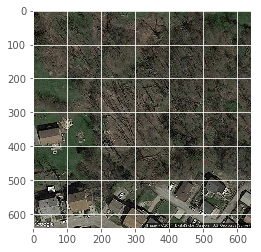

In [10]:
plot_image(im_pitts_0.convert('RGB'))

# Classification Labels

- Get the Target Label (Bins of median income for classification)

In [11]:
def income_to_bins(df, n):
    """ Converts income value into bins of size n
        Args: 
            df : the image dataframe
            n : number of bins
        Returns: 
            df : image df with additional column having bins of median_income
    """
    bins = np.histogram(df.MEDIAN_INCOME, bins=(n-1))[1]
    df['INCOME_BIN'] = [int(np.digitize(df.MEDIAN_INCOME[i],bins)) for i in range(len(df))]
    return df

In [12]:
df_img = income_to_bins(df_img,40)

In [13]:
df_img.head()

ImageName        Lat       Long                GEOID  \
0  Pittsburgh00182.png  40.499737 -80.015609  15000US420032612001   
1  Pittsburgh00316.png  40.498437 -80.017309  15000US420032612001   
2  Pittsburgh00317.png  40.498437 -80.015609  15000US420032612001   
3  Pittsburgh00318.png  40.498437 -80.013909  15000US420032612001   
4  Pittsburgh00319.png  40.498437 -80.012209  15000US420032612001   

   MEDIAN_INCOME  INCOME_BIN  
0        56691.0          13  
1        56691.0          13  
2        56691.0          13  
3        56691.0          13  
4        56691.0          13

In [14]:
min(df_img.INCOME_BIN.values), max(df_img.INCOME_BIN.values)

(1, 40)

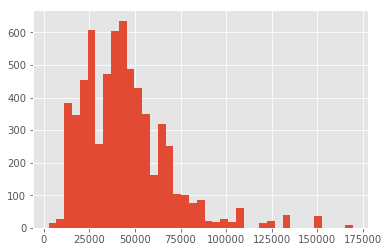

In [15]:
df_img.MEDIAN_INCOME.hist(bins=39)

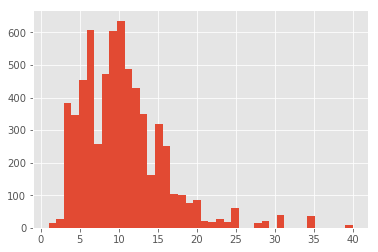

In [16]:
df_img.INCOME_BIN.hist(bins=40)

# Canonicalizing Images

All the images are of size 640x640. Although the images are all of same resolution, we further slice the image into 9 or 16 equal portions.

- 2x2 split = 320x320 size
- 3x3 split = 213.33x213.33 size
- 4x4 split = 160x160 size

In [17]:
import math

def split_image(im, n):
    """ Splits (640x640) image into n parts. 
        Args: 
            im (PIL Image) : image object to split
            n : number of splits
        Returns: 
            im_splits : list of n image objects (PIL Image)
    """
    
    l = im.size[0]
    h = im.size[1]
    parts = int(math.sqrt(n))
    dist = l/parts

    im_splits = []
    for i in range(parts):
        for j in range(parts):
            im_splits.append(im.crop((j*dist, i*dist, (j+1)*dist, (i+1)*dist)))
    return im_splits

In [18]:
im_list = split_image(im_pitts_0.convert('RGB'), 9)
len(im_list)

9

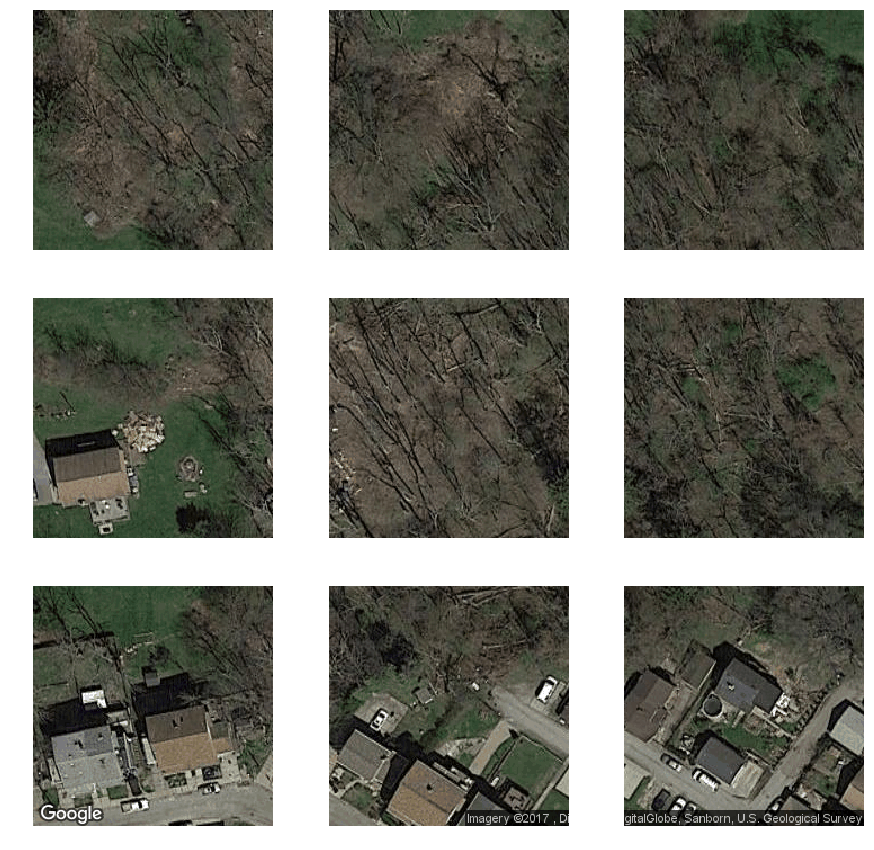

In [19]:
plt.figure(figsize=(15,15))
for i in range(len(im_list)):
    plt.subplot(3,3,i+1)
    plt.axis('off')
    plot_image(im_list[i])

In [20]:
def scale_image(im):
    """ Scales a given image. 
        Args: 
            im (PIL Image) : image object to be scaled
        Returns: 
            (PIL Image) : scaled image object
    """
    return im.resize((100,100),Image.ANTIALIAS)

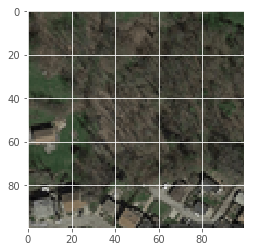

In [21]:
plot_image(scale_image(im_pitts_0.convert('RGB')))

# Train / Validate / Test splits for large datasets

In [22]:
imagefiles = os.listdir(img_path)

im_paths = np.array([img_path+fname for fname in df_img.ImageName])
P = np.random.permutation(len(im_paths))

split = len(P)/3
fnames_tr, fnames_va, fnames_te = im_paths[P[:split]], im_paths[P[split:2*split]], im_paths[P[2*split:]]

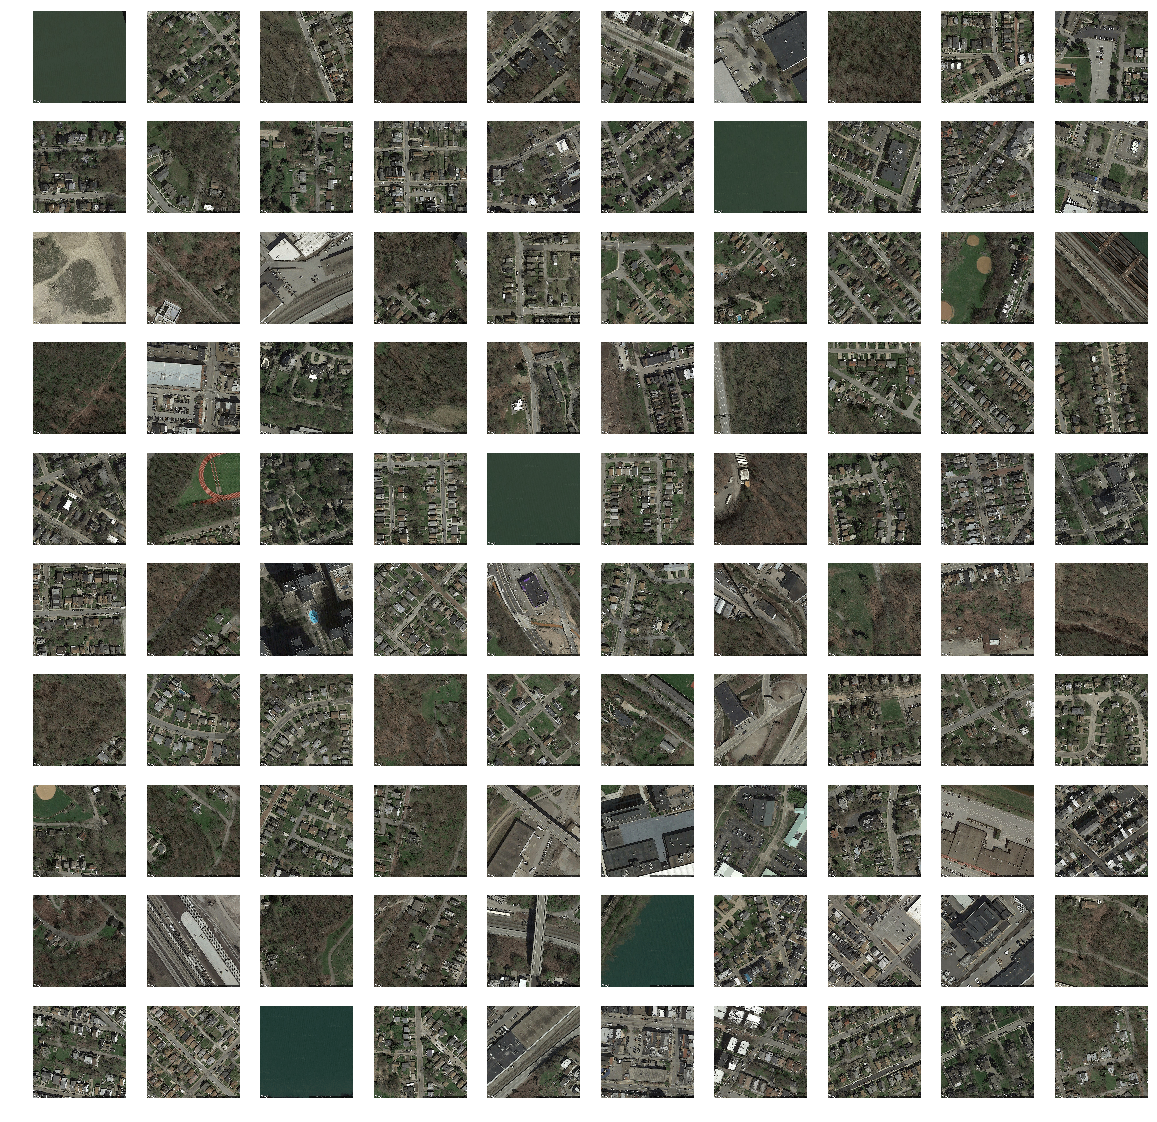

In [23]:
plt.figure(figsize=(20,20))
for i,fname in enumerate(fnames_tr[:100]):
    plt.subplot(10,10,i+1)
    plt.axis('off')
    plot_image(Image.open(fname).convert('RGB'))

- Generate the image data matrix that is to be input into VGG

In [24]:
def map_fname_to_income(img,n):
    """ Replicates the income value n times
        Args: 
            img (string) : the image filename
            n : number of splits of image
        Returns: 
            label (list) : list of income_bin
    """
    df_img_input = pd.DataFrame()
    idx = df_img[df_img.ImageName==img].index
    label = [df_img.loc[idx[0],'INCOME_BIN']]*n
    return label
    
def fname_to_vgg_input(fname,n):
    """ Creates the input for a VGG network from the filename 
        Args: 
            fname (string) : the filename to be parsed
            n : number of splits of image
        Returns: 
            list of (numpy ndarray) : a list of n arrays to be passed into the VGG network
    """    
    im = Image.open(fname).convert('RGB')
    
    if n>1:
        im = split_image(im, n)
    
        img_array = []

        for idx, img in enumerate(im):
            img_array.append(np.rollaxis(np.array(img),2))
    else:
        img_array = np.rollaxis(np.array(im),2)
    return img_array

In [25]:
for i in df_img.iterrows():
    
    img = i[1]['ImageName']
    fname = "../Image/{}".format(img)
    
    print "Median Income:",map_fname_to_income(img,9)
    vgg_input = fname_to_vgg_input(fname,9)
    print "vgg_input: 1 /",len(vgg_input), "=", vgg_input[0]
    break 

Median Income: [13, 13, 13, 13, 13, 13, 13, 13, 13]
vgg_input: 1 / 9 = [[[ 18  18  26 ..., 116  97   8]
  [ 18  32  26 ...,  97  90  40]
  [ 18  26  11 ...,  90  90  40]
  ..., 
  [ 66  66  66 ...,  80  57  64]
  [ 66  66  66 ...,  88  68  68]
  [ 64  66  66 ...,  84  68  68]]

 [[ 18  18  26 ..., 116  91   4]
  [ 17  28  26 ...,  96  90  40]
  [ 17  26  11 ...,  90  90  40]
  ..., 
  [ 82  82  82 ...,  72  51  60]
  [ 82  82  82 ...,  80  68  64]
  [ 76  82  82 ...,  80  64  64]]

 [[ 18  18  24 ..., 100  81   0]
  [ 10  24  24 ...,  84  80  32]
  [ 10  24   4 ...,  80  80  32]
  ..., 
  [ 58  58  58 ...,  60  42  48]
  [ 58  58  58 ...,  68  52  52]
  [ 56  58  58 ...,  64  52  52]]]


# VGG

In [ ]:
import keras
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD

def VGG_16(weights_path=None):
    """ Loads a pretrained VGG network without its dense layers. 
        Args: 
            weights_path (string) : the path to the weights file containing the pretrained weights
        Returns: 
            (keras model) : the VGG-16 model without its dense layers
    """
    
    original_vgg, truncated_vgg = Sequential(), Sequential()
    
    for model, size in zip([original_vgg, truncated_vgg], [244,100]):
        model.add(ZeroPadding2D((1,1),input_shape=(3,size,size)))
        model.add(Convolution2D(64, 3, 3, activation='relu'))
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(64, 3, 3, activation='relu'))
        model.add(MaxPooling2D((2,2), strides=(2,2)))

        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(128, 3, 3, activation='relu'))
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(128, 3, 3, activation='relu'))
        model.add(MaxPooling2D((2,2), strides=(2,2)))

        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(256, 3, 3, activation='relu'))
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(256, 3, 3, activation='relu'))
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(256, 3, 3, activation='relu'))
        model.add(MaxPooling2D((2,2), strides=(2,2)))

        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(512, 3, 3, activation='relu'))
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(512, 3, 3, activation='relu'))
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(512, 3, 3, activation='relu'))
        model.add(MaxPooling2D((2,2), strides=(2,2)))

        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(512, 3, 3, activation='relu'))
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(512, 3, 3, activation='relu'))
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(512, 3, 3, activation='relu'))
        model.add(MaxPooling2D((2,2), strides=(2,2)))
        model.add(Flatten())
        
        if size == 244:
            model.add(Dense(4096, activation='relu'))
            model.add(Dropout(0.5))
            model.add(Dense(4096, activation='relu'))
            model.add(Dropout(0.5))
            model.add(Dense(1000, activation='softmax'))
            
    if weights_path:
        original_vgg.load_weights(weights_path)
    
    k = len(truncated_vgg.layers)
    for l0, l1 in zip(original_vgg.layers[:k], truncated_vgg.layers):
        l1.set_weights(l0.set_weights())

    return truncated_vgg

In [ ]:
truncated_vgg = VGG_16("vgg16_weights.h5")

# Feature Generation